# SVM classifier

This notebook trains a Support Vector Machine (with a linear kernel) to identify relevant tweets (POS).

We use scikit-learn's implementation of SVM and its cross validation tools. http://scikit-learn.org/

## Installation

To install all of the python dependencies for this notbook in a virtual environment:

```bash
# create environment in directory named 'venv'
python -m venv venv
# or:
# virtualenv venv

# activate environment
source venv/bin/activate

# install dependencies
pip3 install -r requirements.txt
```

In [27]:
from class_utils import *
import pickle
import numpy as np

from nltk.tokenize.casual import casual_tokenize
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score,  average_precision_score, precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import auc

In [2]:
# globals
iteration="not-critical"
model_filename = "/Users/amyburkhardt/Documents/NLP/Code/combining-machine-qual/saved_models/best_svc_{}.pickle".format(iteration)

## Parse data sets

Here we parse data from our training files, and then randomly select a portion to be held out for evaluation. The training set is used to both train the SVM classifier and select parameters using k-fold cross validation.

The `parse_training_data()` function is provided in the external `class_utils.py` file.

In [3]:
import os
os.chdir("/Users/amyburkhardt/Documents/NLP/Code/combining-machine-qual/training_data/")
!pwd

/Users/amyburkhardt/Documents/NLP/Code/combining-machine-qual/training_data


In [4]:
# parse data from files
classes = ['NEG', 'POS']
docs, targets = parse_training_data(['NEG.txt'.format(iteration), 'POS-{}.txt'.format(iteration)], classes)

# convert the targets array of strings to binary labels (0=NEG, 1=POS)
lb = LabelBinarizer(sparse_output=False)
lb.fit(classes)
bin_targets = lb.transform(targets).ravel()

# split data set into to training and evaluation sets
# X_test/y_test are held out and not used during the
# k-fold training and parameter search below
#
# The percentage of samples to hod out is determined by the `test_size`
# parameter
# for this iter2, the holdout is only going to be 10% 
X_train, X_test, y_train, y_test = train_test_split(
    docs, bin_targets, test_size=0.10, random_state=0)

In [5]:
len(X_train)

604

In [6]:
len(X_test)

68

## Create sklearn pipeline

Here we setup a scikit-learn pipeline to create vectors from our training sample vocabulary (`CountVectorizer`), normalize words based on frequency (`TfidfTransformer`), and train a SVM classifier (`SVC`). http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

We evaluate parameters based on th `fscore_prec` which is a weighted fscore which favors precision (beta < 1). We also calculate accuracy, precision, recall, and f1 scores for each of the k-fold training sessions.

Using a pipeline makes it easy to search a range of hyperparameters using sklearn's `GridSearchCV`. http://scikit-learn.org/stable/modules/grid_search.html

In [7]:
svc_pl = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='linear')),
])

parameters = {
    'vect__preprocessor': [normalize_tweet],#[normalize_tweet, normalize_simple, None],
    'vect__max_df': np.linspace(0.3, 1.0, 10),
    'vect__tokenizer': [word_tokenize],#[casual_tokenize, word_tokenize, None],
    'vect__ngram_range': [(1,3)],# ((1, 1), (1, 2), (1,3)),  # largest n-gram
    'tfidf__use_idf':[True],# (True, False), #DEFAULT
    'clf__C': [1],# DEFAULT 
    'clf__class_weight': [None],# DEFAULT 
}

# define the scores we want to calcualte during each k-fold training
fscore_prec = make_scorer(fbeta_score, beta=0.5)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'fscore_prec': fscore_prec
}

# create the GridSearchCV object.
# by setting refit='fscore_prec', the model which maximizes that score
# will be selected and retrained on all training data.
svc_search = GridSearchCV(svc_pl, parameters, n_jobs=-1, verbose=1, scoring=scoring, refit='fscore_prec')

In [10]:
# Here we do the actual training
# Can take several minutes depending on the range of parameters given
# int he parameters dict above
svc_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__preprocessor': [<function normalize_tweet at 0x108a00730>], 'vect__max_df': array([0.3    , 0.37778, 0.45556, 0.53333, 0.61111, 0.68889, 0.76667,
       0.84444, 0.92222, 1.     ]), 'vect__tokenizer': [<function word_tokenize at 0x1a0c3378c8>], 'vect__ngram_range': [(1, 3)], 'tfidf__use_idf': [True], 'clf__C': [1], 'clf__class_weight': [None]},
       pre_dispatch='2*n_jobs', refit='fscore_prec',
       return_train_score='warn',
  

In [11]:
svc_search.best_params_

{'clf__C': 1,
 'clf__class_weight': None,
 'tfidf__use_idf': True,
 'vect__max_df': 0.45555555555555555,
 'vect__ngram_range': (1, 3),
 'vect__preprocessor': <function class_utils.normalize_tweet(item)>,
 'vect__tokenizer': <function nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)>}

In [13]:
# print the average scores over the k training folds
fields = ['accuracy', 'precision', 'recall', 'f1', 'fscore_prec']

for f in fields:
    score = svc_search.cv_results_["mean_test_%s" % f][svc_search.best_index_]
    print("%s: %.3f" % (f, score))

accuracy: 0.793
precision: 0.802
recall: 0.430
f1: 0.556
fscore_prec: 0.679


## Results

We check how it works by running the best classifier from the grid search on our held out set.

In [14]:
# Get best model from grid search we ran in previous section
best_model = svc_search.best_estimator_

In [15]:
# use model to predict held out set (X_test) and print score table
# Note that in binary classification, accuracy is the same as the
# [mico averaged recall reported in the table
predictions = best_model.predict(X_test)
print(classification_report(y_test, predictions, target_names=classes))

             precision    recall  f1-score   support

        NEG       0.79      0.94      0.85        47
        POS       0.75      0.43      0.55        21

avg / total       0.77      0.78      0.76        68



In [16]:
scores = [precision_score, recall_score, f1_score,accuracy_score]
for s in scores:
    score = s(y_test, predictions)
    print(score)


0.75
0.42857142857142855
0.5454545454545454
0.7794117647058824


In [17]:
# Print confusion matrix
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
print(confusion_matrix(y_test, predictions))

[[44  3]
 [12  9]]


### precision-recall model

In [21]:
average_precision = average_precision_score(y_test, predictions)

In [26]:
21/68

0.3088235294117647

Text(0.5,1,'2-class Precision-Recall curve: AP=0.50')

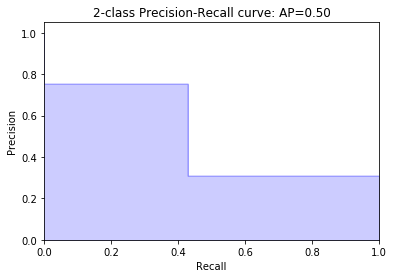

In [25]:
precision, recall, _ = precision_recall_curve(y_test, predictions)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.savefig('books_read.png', dpi=300)

## Persist model

Take our best model, retrain it on entire training dataset (including the held out set used for evaluation above), and persist it to disk.

In [55]:
# retrain on all data
best_model.fit(docs, bin_targets)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.45555555555555555, max_features=None,
        min_df=1, ngram_range=(1, 3),
        preprocessor=<function no...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [57]:
os.chdir("/Users/amyburkhardt/Documents/NLP/Code/combining-machine-qual/saved_models/")
!pwd

/Users/amyburkhardt/Documents/NLP/Code/combining-machine-qual/saved_models


In [60]:
# save to disk
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)